<a href="https://colab.research.google.com/github/SAIcomsci/Malaria_Detection_DeepLearning/blob/main/Malaria_Detection_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install split-folders
#import splitfolders
#input_folder='/content/drive/MyDrive/Malaria detection/MalariaDataset/cell_images'
#splitfolders.ratio(input_folder,output='/content/drive/MyDrive/Malaria detection/MalariaDataset/cell_images',seed=42,ratio=(.63,.07,.3),group_prefix=None)

# Importing necessary libraries

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential

# Loading the data

In [ ]:
train_dir = "/content/drive/MyDrive/Malaria detection/MalariaDataset/cell_images/train"
test_dir = "/content/drive/MyDrive/Malaria detection/MalariaDataset/cell_images/test"
val_dir = "/content/drive/MyDrive/Malaria detection/MalariaDataset/cell_images/val"

## Basic Data information.

In [ ]:
print("Train set:")
print("-"*60)
num_Parasited = len(os.listdir(os.path.join(train_dir, 'Parasitized')))
num_Uninfected = len(os.listdir(os.path.join(train_dir, 'Uninfected')))
print(f"Parasited={num_Parasited}")
print(f"Uninfected={num_Uninfected}")

print("\nTest set:")
print('-'*60)
print(f"Parasited={len(os.listdir(os.path.join(test_dir, 'Parasitized')))}")
print(f"Uninfected={len(os.listdir(os.path.join(test_dir, 'Uninfected')))}")

print("\nValidation set")
print('-'*60)
print(f"Parasited={len(os.listdir(os.path.join(val_dir, 'Parasitized')))}")
print(f"Uninfected={len(os.listdir(os.path.join(val_dir, 'Uninfected')))}")

Train set:
------------------------------------------------------------
Parasited=8681
Uninfected=8372

Test set:
------------------------------------------------------------
Parasited=4135
Uninfected=3988

Validation set
------------------------------------------------------------
Parasited=964
Uninfected=930


# Parasitized cells image

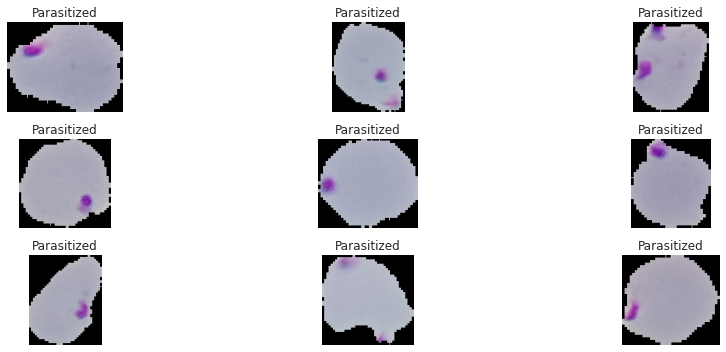

In [ ]:
Parasitized = os.listdir("/content/drive/MyDrive/Malaria detection/MalariaDataset/cell_images/train/Parasitized")
Parasitized_dir = "/content/drive/MyDrive/Malaria detection/MalariaDataset/cell_images/train/Parasitized"
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(Parasitized_dir, Parasitized[i]))
    plt.title("Parasitized")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

plt.tight_layout()

# Uninfected cells image


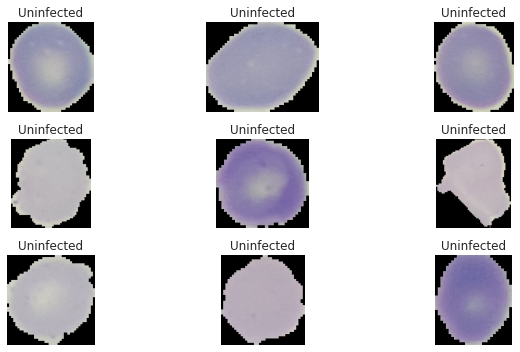

In [ ]:
Uninfected = os.listdir("/content/drive/MyDrive/Malaria detection/MalariaDataset/cell_images/train/Uninfected")
Uninfected_dir = "/content/drive/MyDrive/Malaria detection/MalariaDataset/cell_images/train/Uninfected"

plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(Uninfected_dir, Uninfected[i]))
    plt.title("Uninfected")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()


In [ ]:
import glob

parasitized_train = glob.glob(train_dir+"/Parasitized/*.png")
uninfected_train = glob.glob(train_dir+"/Uninfected/*.png")

- Creating dataframe for counting classes.

In [ ]:
data = pd.DataFrame(np.concatenate([[0]*len(uninfected_train) , [1]*len(parasitized_train)]),columns=["class"])

Labels are: `0 - NORMAL || 1 - PNEUMONIA`

In [ ]:
data.head()

,class
0,0
1,0
2,0
3,0
4,0


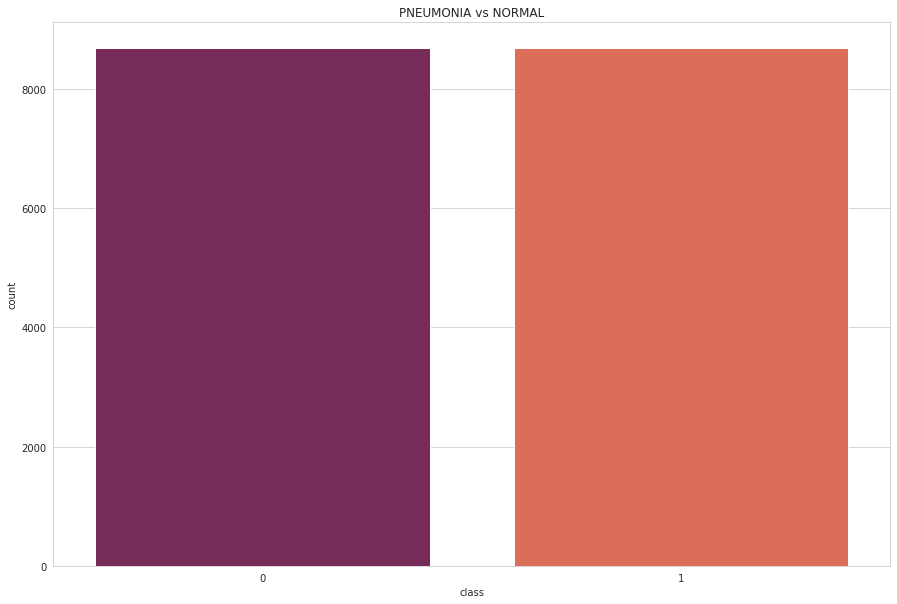

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(data['class'],data=data,palette='rocket')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

### There are more images of PNEUMONIA affected Xrays than NORMAL.

## Data Augmentation
- Using `ImageDataGenerator`, to augment our images so as to create a larger dataset for our model to train on..

In [ ]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,1.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [ ]:

train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=64,
                                       class_mode='categorical',
                                      target_size=(224,224,)
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=64,
                                              class_mode='categorical',
                                             target_size=(224,224,)
                                            )

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=64,
                                       class_mode='categorical',
                                        target_size=(224,224,)
                                      )

Found 17052 images belonging to 2 classes.
Found 1894 images belonging to 2 classes.
Found 8123 images belonging to 2 classes.


In [ ]:
img, label = next(train)

In [ ]:
vgg_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = Flatten()(vgg_model.output)    
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(2,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting // Stop training when a validation loss has stopped improving.
#patience: Number of epochs with no improvement after which training will be stopped
#verbose: Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1,patience=10)


#Reduce learning rate when a metric has stopped improving.
#patience: number of epochs with no improvement after which learning rate will be reduced.
#verbose: int. 0: quiet, 1: update messages.
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',verbose=0,patience=8)

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
history = model.fit(train,epochs=25, 
                    validation_data=validation,
                    #steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=60)

Epoch 1/25
285/285 [==============================] - 2807s 10s/step - loss: 0.5015 - accuracy: 0.7869 - val_loss: 0.3150 - val_accuracy: 0.8881 - lr: 0.0010
Epoch 2/25
285/285 [==============================] - 270s 948ms/step - loss: 0.3359 - accuracy: 0.8569 - val_loss: 0.3327 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 3/25
285/285 [==============================] - 270s 946ms/step - loss: 0.3149 - accuracy: 0.8692 - val_loss: 0.2249 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 4/25
285/285 [==============================] - 268s 939ms/step - loss: 0.2788 - accuracy: 0.8875 - val_loss: 0.2288 - val_accuracy: 0.9213 - lr: 0.0010
Epoch 5/25
285/285 [==============================] - 267s 935ms/step - loss: 0.2785 - accuracy: 0.8857 - val_loss: 0.2383 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 6/25
285/285 [==============================] - 269s 944ms/step - loss: 0.2627 - accuracy: 0.8944 - val_loss: 0.2058 - val_accuracy: 0.9271 - lr: 0.0010
Epoch 7/25
285/285 [===========================

# Evaluating the VGG16



In [ ]:

# Evaluating the model on train and test
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

285/285 [==============================] - 273s 957ms/step - loss: 0.2130 - accuracy: 0.9154
Train Loss:  0.2130027711391449
Train Accuracy:  0.9154351353645325


In [ ]:
# Test data
score = model.evaluate(test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

136/136 [==============================] - 1948s 14s/step - loss: 0.1746 - accuracy: 0.9323
Test Loss:  0.1746484786272049
Test Accuracy:  0.9322910308837891


Text(0.5, 1.0, 'Accuracy Evolution')

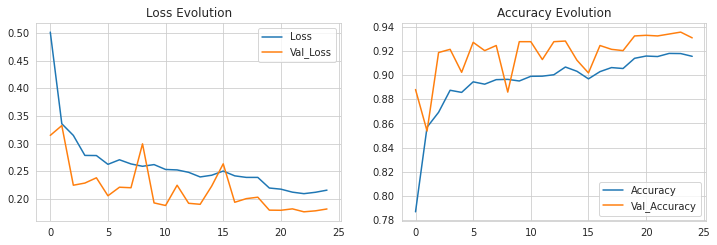

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG16')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
vgg_model1= tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in vgg_model1.layers:
    layer.trainable=False
    
x = Flatten()(vgg_model1.output)    
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(2,activation='sigmoid')(x)

model1= tf.keras.Model(inputs=vgg_model1.input, outputs=predictions)

# to avoid overfitting // Stop training when a validation loss has stopped improving.
#patience: Number of epochs with no improvement after which training will be stopped
#verbose: Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1,patience=10)


#Reduce learning rate when a metric has stopped improving.
#patience: number of epochs with no improvement after which learning rate will be reduced.
#verbose: int. 0: quiet, 1: update messages.
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',verbose=1,patience=8)

# Compiling the model
model1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:

model1_history = model1.fit(train,epochs=25, 
                    validation_data=validation,
                     #steps_per_epoch=530,
                    callbacks=[early_stopping,lr],
                    #batch_size=32
                    )

Epoch 1/25
285/285 [==============================] - 2606s 9s/step - loss: 0.6320 - accuracy: 0.7605 - val_loss: 0.3421 - val_accuracy: 0.8522 - lr: 0.0010
Epoch 2/25
285/285 [==============================] - 278s 974ms/step - loss: 0.3740 - accuracy: 0.8359 - val_loss: 0.4300 - val_accuracy: 0.8004 - lr: 0.0010
Epoch 3/25
285/285 [==============================] - 282s 989ms/step - loss: 0.3549 - accuracy: 0.8489 - val_loss: 0.2942 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 4/25
285/285 [==============================] - 276s 966ms/step - loss: 0.3303 - accuracy: 0.8625 - val_loss: 0.3964 - val_accuracy: 0.8231 - lr: 0.0010
Epoch 5/25
285/285 [==============================] - 277s 973ms/step - loss: 0.3394 - accuracy: 0.8548 - val_loss: 0.4270 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 6/25
285/285 [==============================] - 275s 964ms/step - loss: 0.3273 - accuracy: 0.8598 - val_loss: 0.2720 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 7/25
285/285 [============================

In [ ]:
# Evaluating the model on train data
score = model1.evaluate(train,verbose=1)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

285/285 [==============================] - 266s 934ms/step - loss: 0.2458 - accuracy: 0.9024
Train Loss:  0.24579961597919464
Train Accuracy:  0.9024161100387573


In [ ]:
# Test data
score = model1.evaluate(test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

136/136 [==============================] - 1723s 13s/step - loss: 0.2176 - accuracy: 0.9130
Test Loss:  0.21757455170154572
Test Accuracy:  0.9129632115364075


Text(0.5, 1.0, 'Accuracy Evolution')

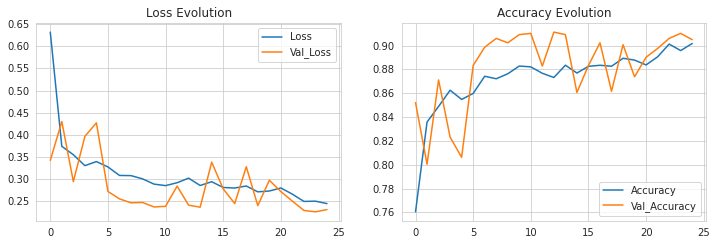

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG16')

plt.subplot(2, 2, 1)
plt.plot(model1_history.history['loss'], label='Loss')
plt.plot(model1_history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(model1_history.history['accuracy'], label='Accuracy')
plt.plot(model1_history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(2,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

94683136/94668760 [==============================] - 0s 0us/step


In [ ]:
history = model2.fit(train,epochs=25, 
                    validation_data=validation,
                     #steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=64
                )

Epoch 1/25
267/267 [==============================] - 2714s 10s/step - loss: 0.3069 - accuracy: 0.8744 - val_loss: 0.2020 - val_accuracy: 0.9197 - lr: 0.0010
Epoch 2/25
267/267 [==============================] - 262s 980ms/step - loss: 0.2382 - accuracy: 0.9047 - val_loss: 0.1855 - val_accuracy: 0.9282 - lr: 0.0010
Epoch 3/25
267/267 [==============================] - 260s 972ms/step - loss: 0.2308 - accuracy: 0.9100 - val_loss: 0.1772 - val_accuracy: 0.9308 - lr: 0.0010
Epoch 4/25
267/267 [==============================] - 261s 979ms/step - loss: 0.2296 - accuracy: 0.9111 - val_loss: 0.1807 - val_accuracy: 0.9282 - lr: 0.0010
Epoch 5/25
267/267 [==============================] - 260s 973ms/step - loss: 0.2260 - accuracy: 0.9129 - val_loss: 0.1743 - val_accuracy: 0.9351 - lr: 0.0010
Epoch 6/25
267/267 [==============================] - 262s 981ms/step - loss: 0.2151 - accuracy: 0.9161 - val_loss: 0.1683 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 7/25
267/267 [===========================

In [ ]:
# Evaluating the model on train and test
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

543/543 [==============================] - 427s 785ms/step - loss: 0.2263 - accuracy: 0.9165
Train Loss:  0.22632214426994324
Train Accuracy:  0.9164746403694153
4135/4135 [==============================] - 145s 35ms/step - loss: 0.1624 - accuracy: 0.9394

Test loss:  0.16238541901111603
Test Accuracy:  0.9394195675849915


Text(0.5, 1.0, 'Accuracy Evolution')

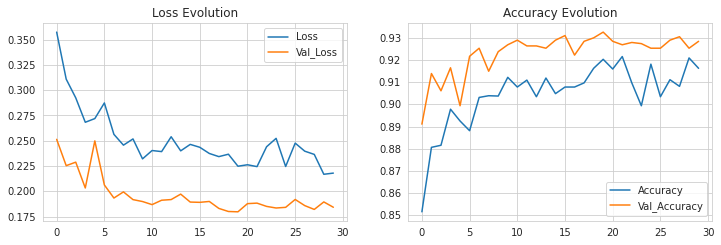

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

# Observation:
- `ResNet50V2` perofmed well and looks better on the graph than `VGG19`. 

# Fine Tuning
- One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier that has been added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [ ]:
resnet_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [ ]:
# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
len(model2.trainable_variables)

86

In [ ]:
fine_tune_epochs = 10
epochs_on_raw_model = 30

total_epochs =  epochs_on_raw_model + fine_tune_epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

history_fine =model2.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    #steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    #batch_size=32
                    )

Epoch 1/40
267/267 [==============================] - 282s 1s/step - loss: 0.1971 - accuracy: 0.9337 - val_loss: 0.1699 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 2/40
267/267 [==============================] - 271s 1s/step - loss: 0.1576 - accuracy: 0.9454 - val_loss: 0.1574 - val_accuracy: 0.9551 - lr: 0.0010
Epoch 3/40
267/267 [==============================] - 272s 1s/step - loss: 0.1537 - accuracy: 0.9446 - val_loss: 0.1351 - val_accuracy: 0.9546 - lr: 0.0010
Epoch 4/40
267/267 [==============================] - 275s 1s/step - loss: 0.1452 - accuracy: 0.9488 - val_loss: 0.1215 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 5/40
267/267 [==============================] - 272s 1s/step - loss: 0.1415 - accuracy: 0.9490 - val_loss: 0.1348 - val_accuracy: 0.9609 - lr: 0.0010
Epoch 6/40
267/267 [==============================] - 274s 1s/step - loss: 0.1409 - accuracy: 0.9490 - val_loss: 0.1323 - val_accuracy: 0.9599 - lr: 0.0010
Epoch 7/40
267/267 [==============================] - 273s 1s/st

# Evaluating the Fine Tune model

In [ ]:
# Evaluating the model on train and test
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

267/267 [==============================] - 254s 949ms/step - loss: 0.0914 - accuracy: 0.9673
Train Loss:  0.09143716841936111
Train Accuracy:  0.9672765731811523
127/127 [==============================] - 2117s 17s/step - loss: 0.0752 - accuracy: 0.9730

Test loss:  0.07520678639411926
Test Accuracy:  0.9730395078659058


Text(0.5, 1.0, 'Accuracy Evolution')

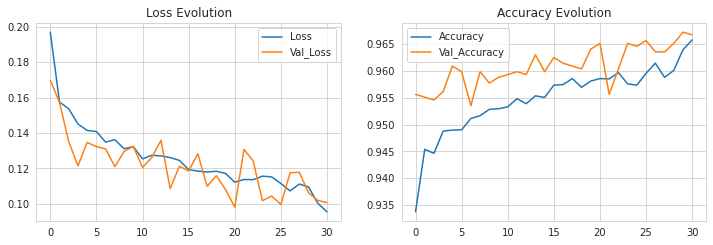

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

- After fine tuning on `ResNet50V2` we got accuracy on test data is `~97%`
